In [371]:
import numpy as np
import pandas as pd
from geopy.distance import geodesic as GD
from geopy.geocoders import Nominatim
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)
from functools import lru_cache
from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

import warnings

## 1. Display Settings

In [318]:
pd.set_option("display.max_columns", None)
sklearn.set_config(transform_output="pandas")
warnings.filterwarnings("ignore")

In [319]:
geolocator = Nominatim(user_agent="MyApp")

## 2. Read the data

In [320]:
train = pd.read_csv(r"C:\Users\yashg\OneDrive\Desktop\flight-sagemaker\data\train.csv")
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-05-27,Delhi,Cochin,20:55:00,12:35:00,940,1,In-flight meal not included,12898
1,Jet Airways,2019-06-12,Kolkata,Banglore,18:55:00,16:20:00,1285,1,No info,13044
2,Air India,2019-05-18,Delhi,Cochin,09:45:00,09:25:00,1420,2,No info,10975
3,IndiGo,2019-06-03,Mumbai,Hyderabad,21:20:00,22:50:00,90,0,No info,2227
4,Jet Airways,2019-04-01,Mumbai,Hyderabad,02:55:00,04:20:00,85,0,No info,5678


In [321]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6694 entries, 0 to 6693
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   airline          6694 non-null   object
 1   date_of_journey  6694 non-null   object
 2   source           6694 non-null   object
 3   destination      6694 non-null   object
 4   dep_time         6694 non-null   object
 5   arrival_time     6694 non-null   object
 6   duration         6694 non-null   int64 
 7   total_stops      6694 non-null   int64 
 8   additional_info  6694 non-null   object
 9   price            6694 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 523.1+ KB


In [322]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

## Changing Y_train

In [368]:
y_train

0       12898
1       13044
2       10975
3        2227
4        5678
        ...  
6689     8479
6690    15078
6691     8603
6692     8759
6693    11142
Name: price, Length: 6694, dtype: int64

## 4.2 Airline

In [323]:
X_train.airline

0             Jet Airways
1             Jet Airways
2               Air India
3                  IndiGo
4             Jet Airways
              ...        
6689             SpiceJet
6690    Multiple carriers
6691            Air India
6692             Air Asia
6693    Multiple carriers
Name: airline, Length: 6694, dtype: object

In [324]:
airline_transformer = Pipeline(steps = [
                                    ("imputer", SimpleImputer(strategy="most_frequent")),
                                    ("grouper", RareLabelEncoder(tol=  0.05, replace_with = "Other", n_categories=2)),
                                    # ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
                                    ("encoder", MeanEncoder()),
                                	("scaler", PowerTransformer())
    
])

In [325]:
airline_transformer.fit_transform(X_train.loc[:, ["airline"]], y_train)

,airline
0,1.027531
1,1.027531
2,0.095270
3,-1.243225
4,1.027531
...,...
6689,-1.573432
6690,0.620932
6691,0.095270
6692,-0.942493


In [326]:
air_transformer

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('grouper',
                 RareLabelEncoder(n_categories=2, replace_with='Other')),
                ('encoder', MeanEncoder()), ('scaler', PowerTransformer())])

## 4.3 date_of_journey

In [327]:
X_train.date_of_journey

0       2019-05-27
1       2019-06-12
2       2019-05-18
3       2019-06-03
4       2019-04-01
           ...    
6689    2019-06-09
6690    2019-05-09
6691    2019-05-18
6692    2019-05-18
6693    2019-04-09
Name: date_of_journey, Length: 6694, dtype: object

In [328]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.666667,0.764706,0.000000,0.737288
1,1.000000,0.882353,0.333333,0.872881
2,0.666667,0.647059,0.833333,0.661017
3,1.000000,0.823529,0.000000,0.796610
4,0.333333,0.294118,0.000000,0.262712
...,...,...,...,...
6689,1.000000,0.823529,1.000000,0.847458
6690,0.666667,0.588235,0.500000,0.584746
6691,0.666667,0.647059,0.833333,0.661017
6692,0.666667,0.647059,0.833333,0.661017


In [329]:
doj_transformer

Pipeline(steps=[('dt',
                 DatetimeFeatures(features_to_extract=['month', 'week',
                                                       'day_of_week',
                                                       'day_of_year'],
                                  format='mixed', yearfirst=True)),
                ('scaler', MinMaxScaler())])

### 4.3 source & destination

In [330]:
X_train.source

0         Delhi
1       Kolkata
2         Delhi
3        Mumbai
4        Mumbai
         ...   
6689    Kolkata
6690      Delhi
6691      Delhi
6692      Delhi
6693      Delhi
Name: source, Length: 6694, dtype: object

In [331]:
X_train.destination

0          Cochin
1        Banglore
2          Cochin
3       Hyderabad
4       Hyderabad
          ...    
6689     Banglore
6690       Cochin
6691       Cochin
6692       Cochin
6693       Cochin
Name: destination, Length: 6694, dtype: object

In [332]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Kolkata,Banglore
2,Delhi,Cochin
3,Mumbai,Hyderabad
4,Mumbai,Hyderabad
...,...,...
6689,Kolkata,Banglore
6690,Delhi,Cochin
6691,Delhi,Cochin
6692,Delhi,Cochin


In [333]:
# location_pipe1 = Pipeline(steps=[
#     ("frequency", CountFrequencyEncoder()),
#     ("StandardScaler", StandardScaler())

# ])

# location_pipe1.fit_transform(location_subset, y_train)

In [334]:
np.union1d(
	X_train.source.unique(),
	X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai'], dtype=object)

In [335]:
def label_source_destination_func(X):
    label_source_destination_list = {
    'Banglore':1, 'Chennai':2, 'Cochin':3, 'Delhi':4, 'Hyderabad':5, 'Kolkata':6,
       'Mumbai':7
        }
    source = X["source"].map(label_source_destination_list)
    destination = X["destination"].map(label_source_destination_list)
    df = pd.DataFrame({"labeled_source": source, "labeled_destination": destination})
    return df

FunctionTransformer(func=label_source_destination_func).fit_transform(location_subset)

,labeled_source,labeled_destination
0,4,3
1,6,1
2,4,3
3,7,5
4,7,5
...,...,...
6689,6,1
6690,4,3
6691,4,3
6692,4,3


In [336]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
6689,1,0
6690,1,0
6691,1,0
6692,1,0


In [337]:
# Use caching to store previously computed distances
@lru_cache(maxsize=None)
def get_lat_long(city):
    """Get latitude and longitude for a given city."""
    location = geolocator.geocode(f"{city}, India")
    if location:
        return location.latitude, location.longitude
    else:
        return None

def distance_between_cities(source, destination):
    """Calculate the distance between two cities using geopy."""
    lat_long_city1 = get_lat_long(source)
    lat_long_city2 = get_lat_long(destination)

    # Check if both cities returned valid coordinates
    if lat_long_city1 and lat_long_city2:
        distance = GD(lat_long_city1, lat_long_city2).km
        return distance
    else:
        return None  # Return None if any city has missing coordinates

def return_distance_df(train):
    """Apply distance calculation to each row in the DataFrame."""
    distance = train.apply(lambda row: distance_between_cities(row['source'], row['destination']), axis=1)
    return pd.DataFrame(distance, columns=["distance_between_cities"])


In [338]:
location_pipe2 = Pipeline(steps=[
	("encoder", FunctionTransformer(func=return_distance_df)),
    ("StandardScaler", StandardScaler())
])

location_pipe2.fit_transform(location_subset)

,distance_between_cities
0,0.878694
1,-0.480566
2,0.878694
3,-2.947900
4,-2.947900
...,...
6689,-0.480566
6690,0.878694
6691,0.878694
6692,0.878694


In [339]:
location_transformer = FeatureUnion(transformer_list=[
	("part2", FunctionTransformer(func=is_north)),
    ("part3", location_pipe2),
    ("part4", FunctionTransformer(func=label_source_destination_func))
])

location_transformer.fit_transform(location_subset, y_train)

,source_is_north,destination_is_north,distance_between_cities,labeled_source,labeled_destination
0,1,0,0.878694,4,3
1,1,0,-0.480566,6,1
2,1,0,0.878694,4,3
3,1,0,-2.947900,7,5
4,1,0,-2.947900,7,5
...,...,...,...,...,...
6689,1,0,-0.480566,6,1
6690,1,0,0.878694,4,3
6691,1,0,0.878694,4,3
6692,1,0,0.878694,4,3


In [340]:
location_transformer

FeatureUnion(transformer_list=[('part2',
                                FunctionTransformer(func=<function is_north at 0x00000241B9755DA0>)),
                               ('part3',
                                Pipeline(steps=[('encoder',
                                                 FunctionTransformer(func=<function return_distance_df at 0x00000241B9757B00>)),
                                                ('StandardScaler',
                                                 StandardScaler())])),
                               ('part4',
                                FunctionTransformer(func=<function label_source_destination_func at 0x00000241B9756E80>))])

### 4.4 dep_time & arrival_time

In [341]:
X_train.dep_time

0       20:55:00
1       18:55:00
2       09:45:00
3       21:20:00
4       02:55:00
          ...   
6689    11:35:00
6690    10:00:00
6691    12:00:00
6692    07:55:00
6693    08:00:00
Name: dep_time, Length: 6694, dtype: object

In [342]:
X_train.arrival_time

0       12:35:00
1       16:20:00
2       09:25:00
3       22:50:00
4       04:20:00
          ...   
6689    18:50:00
6690    01:30:00
6691    07:40:00
6692    13:25:00
6693    19:00:00
Name: arrival_time, Length: 6694, dtype: object

In [343]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,20:55:00,12:35:00
1,18:55:00,16:20:00
2,09:45:00,09:25:00
3,21:20:00,22:50:00
4,02:55:00,04:20:00
...,...,...
6689,11:35:00,18:50:00
6690,10:00:00,01:30:00
6691,12:00:00,07:40:00
6692,07:55:00,13:25:00


In [344]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.869565,1.000000,0.521739,0.636364
1,0.782609,1.000000,0.695652,0.363636
2,0.391304,0.818182,0.391304,0.454545
3,0.913043,0.363636,0.956522,0.909091
4,0.086957,1.000000,0.173913,0.363636
...,...,...,...,...
6689,0.478261,0.636364,0.782609,0.909091
6690,0.434783,0.000000,0.043478,0.545455
6691,0.521739,0.000000,0.304348,0.727273
6692,0.304348,1.000000,0.565217,0.454545


In [345]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,night,afternoon
1,evening,evening
2,morning,morning
3,night,night
4,night,morning
...,...,...
6689,morning,evening
6690,morning,night
6691,afternoon,morning
6692,morning,afternoon


In [346]:
def part_of_day_label_encoding(X):
    label_part_of_day_list = {
    'morning':1, 'afternoon':2, 'evening':3, 'night':4}
    dep = X["dep_time_part_of_day"].map(label_part_of_day_list)
    arrival = X["arrival_time_part_of_day"].map(label_part_of_day_list)
    df = pd.DataFrame({"dep_time_part_of_day": dep, "arrival_time_part_of_day": arrival})
    return df
    

In [347]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTaransformer(func=part_of_day)),
	("label_encoder", FunctionTransformer(func=part_of_day_label_encoding))
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,4,2
1,3,3
2,1,1
3,4,4
4,4,1
...,...,...
6689,1,3
6690,1,4
6691,2,1
6692,1,2


In [348]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.869565,1.000000,0.521739,0.636364,4,2
1,0.782609,1.000000,0.695652,0.363636,3,3
2,0.391304,0.818182,0.391304,0.454545,1,1
3,0.913043,0.363636,0.956522,0.909091,4,4
4,0.086957,1.000000,0.173913,0.363636,4,1
...,...,...,...,...,...,...
6689,0.478261,0.636364,0.782609,0.909091,1,3
6690,0.434783,0.000000,0.043478,0.545455,1,4
6691,0.521739,0.000000,0.304348,0.727273,2,1
6692,0.304348,1.000000,0.565217,0.454545,1,2


In [349]:
time_transformer

FeatureUnion(transformer_list=[('part1',
                                Pipeline(steps=[('dt',
                                                 DatetimeFeatures(features_to_extract=['hour',
                                                                                       'minute'])),
                                                ('scaler', MinMaxScaler())])),
                               ('part2',
                                Pipeline(steps=[('part',
                                                 FunctionTransformer(func=<function part_of_day at 0x00000241B8CAD3A0>)),
                                                ('label_encoder',
                                                 FunctionTransformer(func=<function part_of_day_label_encoding at 0x00000241B8CAD260>))]))])

## 4.5 duration

In [350]:
X_train.duration

0        940
1       1285
2       1420
3         90
4         85
        ... 
6689     435
6690     930
6691    1180
6692     330
6693     660
Name: duration, Length: 6694, dtype: int64

In [351]:
def duration_category(X, short=170, med=925):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [352]:
duration_category(X_train, short=170, med=925)

,airline,date_of_journey,source,destination,dep_time,arrival_time,total_stops,additional_info,duration_cat
0,Jet Airways,2019-05-27,Delhi,Cochin,20:55:00,12:35:00,1,In-flight meal not included,long
1,Jet Airways,2019-06-12,Kolkata,Banglore,18:55:00,16:20:00,1,No info,long
2,Air India,2019-05-18,Delhi,Cochin,09:45:00,09:25:00,2,No info,long
3,IndiGo,2019-06-03,Mumbai,Hyderabad,21:20:00,22:50:00,0,No info,short
4,Jet Airways,2019-04-01,Mumbai,Hyderabad,02:55:00,04:20:00,0,No info,short
...,...,...,...,...,...,...,...,...,...
6689,SpiceJet,2019-06-09,Kolkata,Banglore,11:35:00,18:50:00,1,No info,medium
6690,Multiple carriers,2019-05-09,Delhi,Cochin,10:00:00,01:30:00,1,No info,long
6691,Air India,2019-05-18,Delhi,Cochin,12:00:00,07:40:00,2,No info,long
6692,Air Asia,2019-05-18,Delhi,Cochin,07:55:00,13:25:00,1,No info,medium


In [353]:
def is_over(X, value=925):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [354]:
is_over(X_train)

,airline,date_of_journey,source,destination,dep_time,arrival_time,total_stops,additional_info,duration_over_925
0,Jet Airways,2019-05-27,Delhi,Cochin,20:55:00,12:35:00,1,In-flight meal not included,1
1,Jet Airways,2019-06-12,Kolkata,Banglore,18:55:00,16:20:00,1,No info,1
2,Air India,2019-05-18,Delhi,Cochin,09:45:00,09:25:00,2,No info,1
3,IndiGo,2019-06-03,Mumbai,Hyderabad,21:20:00,22:50:00,0,No info,0
4,Jet Airways,2019-04-01,Mumbai,Hyderabad,02:55:00,04:20:00,0,No info,0
...,...,...,...,...,...,...,...,...,...
6689,SpiceJet,2019-06-09,Kolkata,Banglore,11:35:00,18:50:00,1,No info,0
6690,Multiple carriers,2019-05-09,Delhi,Cochin,10:00:00,01:30:00,1,No info,1
6691,Air India,2019-05-18,Delhi,Cochin,12:00:00,07:40:00,2,No info,1
6692,Air Asia,2019-05-18,Delhi,Cochin,07:55:00,13:25:00,1,No info,0


In [355]:
duration_pipe = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe),
	("part2", FunctionTransformer(func=is_over)),
	("part3", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_cat,duration_over_925,duration
0,2.0,1,0.609935
1,2.0,1,1.301752
2,2.0,1,1.572463
3,0.0,0,-1.094542
4,0.0,0,-1.104568
...,...,...,...
6689,1.0,0,-0.402725
6690,2.0,1,0.589882
6691,2.0,1,1.091199
6692,1.0,0,-0.613278


In [356]:
duration_transformer

Pipeline(steps=[('outliers', Winsorizer(capping_method='iqr', fold=1.5)),
                ('imputer', SimpleImputer(strategy='median')),
                ('union',
                 FeatureUnion(transformer_list=[('part1',
                                                 Pipeline(steps=[('cat',
                                                                  FunctionTransformer(func=<function duration_category at 0x00000241B8CAF9C0>)),
                                                                 ('encoder',
                                                                  OrdinalEncoder(categories=[['short',
                                                                                              'medium',
                                                                                              'long']]))])),
                                                ('part2',
                                                 FunctionTransformer(func=<function is_over at 0x00000241B8CAE8E0>)),
                                                ('part3', StandardScaler())]))])

### 4.6 total_stops

In [357]:
X_train.total_stops

0       1
1       1
2       2
3       0
4       0
       ..
6689    1
6690    1
6691    2
6692    1
6693    1
Name: total_stops, Length: 6694, dtype: int64

In [358]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1,0
1,1,0
2,2,0
3,0,1
4,0,1
...,...,...
6689,1,0
6690,1,0
6691,2,0
6692,1,0


### 4.7 additional_info

In [359]:
X_train["additional_info"]

0       In-flight meal not included
1                           No info
2                           No info
3                           No info
4                           No info
                   ...             
6689                        No info
6690                        No info
6691                        No info
6692                        No info
6693                        No info
Name: additional_info, Length: 6694, dtype: object

In [415]:
additional_info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=  0.2, replace_with = "Other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("StandardScaler", StandardScaler())
])

additional_info_transformer.fit_transform(X_train.loc[:, ["additional_info"]], y_train)

,additional_info
0,-1.885959
1,0.530234
2,0.530234
3,0.530234
4,0.530234
...,...
6689,0.530234
6690,0.530234
6691,0.530234
6692,0.530234


In [416]:
a = additional_info_transformer.fit_transform(X_train.loc[:, ["additional_info"]], y_train)

In [417]:
a["price"] = y_train

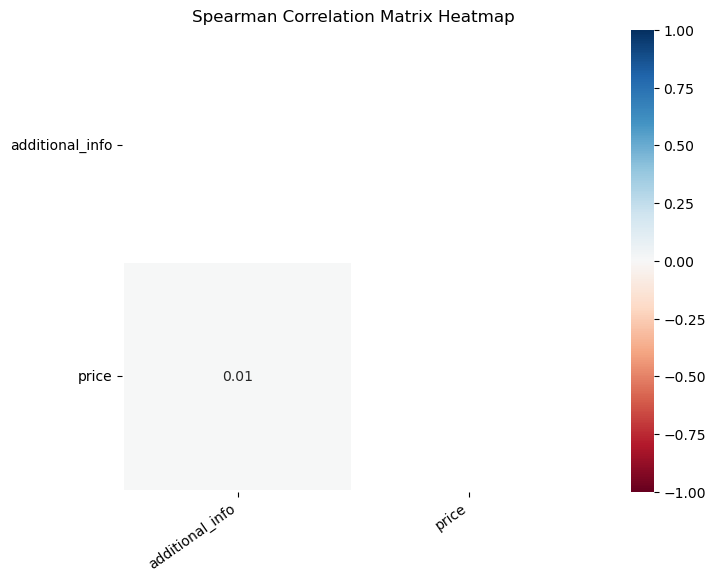

In [418]:
eda_helper_functions.correlation_heatmap(a)

In [361]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
    ("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
    ("stops", total_stops_transformer, ["total_stops"]),
     ("additional_info", additional_info_transformer, ["additional_info"])],remainder="passthrough" ) 

column_transformer.fit_transform(X_train, y_train)

,air__airline,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source_is_north,location__destination_is_north,location__distance_between_cities,location__labeled_source,location__labeled_destination,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_cat,dur__duration_over_925,dur__duration,stops__total_stops,stops__is_direct_flight,additional_info__additional_info_In-flight meal not included,additional_info__additional_info_No info,additional_info__additional_info_Other
0,1.027531,0.666667,0.764706,0.000000,0.737288,1,0,0.878694,4,3,0.869565,1.000000,0.521739,0.636364,4,2,2.0,1,0.609935,1,0,1.0,0.0,0.0
1,1.027531,1.000000,0.882353,0.333333,0.872881,1,0,-0.480566,6,1,0.782609,1.000000,0.695652,0.363636,3,3,2.0,1,1.301752,1,0,0.0,1.0,0.0
2,0.095270,0.666667,0.647059,0.833333,0.661017,1,0,0.878694,4,3,0.391304,0.818182,0.391304,0.454545,1,1,2.0,1,1.572463,2,0,0.0,1.0,0.0
3,-1.243225,1.000000,0.823529,0.000000,0.796610,1,0,-2.947900,7,5,0.913043,0.363636,0.956522,0.909091,4,4,0.0,0,-1.094542,0,1,0.0,1.0,0.0
4,1.027531,0.333333,0.294118,0.000000,0.262712,1,0,-2.947900,7,5,0.086957,1.000000,0.173913,0.363636,4,1,0.0,0,-1.104568,0,1,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6689,-1.573432,1.000000,0.823529,1.000000,0.847458,1,0,-0.480566,6,1,0.478261,0.636364,0.782609,0.909091,1,3,1.0,0,-0.402725,1,0,0.0,1.0,0.0
6690,0.620932,0.666667,0.588235,0.500000,0.584746,1,0,0.878694,4,3,0.434783,0.000000,0.043478,0.545455,1,4,2.0,1,0.589882,1,0,0.0,1.0,0.0
6691,0.095270,0.666667,0.647059,0.833333,0.661017,1,0,0.878694,4,3,0.521739,0.000000,0.304348,0.727273,2,1,2.0,1,1.091199,2,0,0.0,1.0,0.0
6692,-0.942493,0.666667,0.647059,0.833333,0.661017,1,0,0.878694,4,3,0.304348,1.000000,0.565217,0.454545,1,2,1.0,0,-0.613278,1,0,0.0,1.0,0.0


In [362]:
column_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('air',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('grouper',
                                                  RareLabelEncoder(n_categories=2,
                                                                   replace_with='Other')),
                                                 ('encoder', MeanEncoder()),
                                                 ('scaler',
                                                  PowerTransformer())]),
                                 ['airline']),
                                ('doj',
                                 Pipeline(steps=[('dt',
                                                  DatetimeFeatures(features_to_extract=['month',
                                                                                        'week',...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('',
                                                  FunctionTransformer(func=<function is_direct at 0x00000241B9B37D80>))]),
                                 ['total_stops']),
                                ('additional_info',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('grouper',
                                                  RareLabelEncoder(n_categories=2,
                                                                   replace_with='Other',
                                                                   tol=0.1)),
                                                 ('encoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['additional_info'])])

### 5. Feature Selection

In [382]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

### 6. Putting it all Together

In [383]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__distance_between_cities,location__labeled_source,location__labeled_destination,dur__duration_cat,dur__duration_over_925,dur__duration,stops__total_stops,stops__is_direct_flight
0,1.027531,0.764706,0.737288,0.878694,4,3,2.0,1,0.609935,1,0
1,1.027531,0.882353,0.872881,-0.480566,6,1,2.0,1,1.301752,1,0
2,0.095270,0.647059,0.661017,0.878694,4,3,2.0,1,1.572463,2,0
3,-1.243225,0.823529,0.796610,-2.947900,7,5,0.0,0,-1.094542,0,1
4,1.027531,0.294118,0.262712,-2.947900,7,5,0.0,0,-1.104568,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6689,-1.573432,0.823529,0.847458,-0.480566,6,1,1.0,0,-0.402725,1,0
6690,0.620932,0.588235,0.584746,0.878694,4,3,2.0,1,0.589882,1,0
6691,0.095270,0.647059,0.661017,0.878694,4,3,2.0,1,1.091199,2,0
6692,-0.942493,0.647059,0.661017,0.878694,4,3,1.0,0,-0.613278,1,0


### Visualization

In [384]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline': 0.34184784725241535,
 'doj__date_of_journey_month': 0.0812870080325477,
 'doj__date_of_journey_week': 0.17136121485343714,
 'doj__date_of_journey_day_of_week': 0.0003741447761493137,
 'doj__date_of_journey_day_of_year': 0.2102901279675218,
 'location__source_is_north': 0.02805586604300292,
 'location__destination_is_north': 0.02805586604300292,
 'location__distance_between_cities': 0.1257139940308999,
 'location__labeled_source': 0.1257139940308999,
 'location__labeled_destination': 0.1257139940308999,
 'time__dep_time_hour': 0.008700429329426865,
 'time__dep_time_minute': 0.030920173015736352,
 'time__arrival_time_hour': 0.07474905769938267,
 'time__arrival_time_minute': 0.030441405773096213,
 'time__dep_time_part_of_day': -0.00057196039840172,
 'time__arrival_time_part_of_day': 0.030083789472431028,
 'dur__duration_cat': 0.2697457059204948,
 'dur__duration_over_925': 0.10134950326329846,
 'dur__duration': 0.4163033619030667,
 'stops__total_stops': 0.3890563531349809,

In [385]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'additional_info__additional_info_No info': -0.0005781927789604661,
 'time__dep_time_part_of_day': -0.00057196039840172,
 'doj__date_of_journey_day_of_week': 0.0003741447761493137,
 'additional_info__additional_info_In-flight meal not included': 0.001739383790001492,
 'time__dep_time_hour': 0.008700429329426865,
 'additional_info__additional_info_Other': 0.018058302729737557,
 'location__source_is_north': 0.02805586604300292,
 'location__destination_is_north': 0.02805586604300292,
 'time__arrival_time_part_of_day': 0.030083789472431028,
 'time__arrival_time_minute': 0.030441405773096213,
 'time__dep_time_minute': 0.030920173015736352,
 'time__arrival_time_hour': 0.07474905769938267,
 'doj__date_of_journey_month': 0.0812870080325477,
 'dur__duration_over_925': 0.10134950326329846,
 'location__distance_between_cities': 0.1257139940308999,
 'location__labeled_source': 0.1257139940308999,
 'location__labeled_destination': 0.1257139940308999,
 'doj__date_of_journey_week': 0.171361214853437

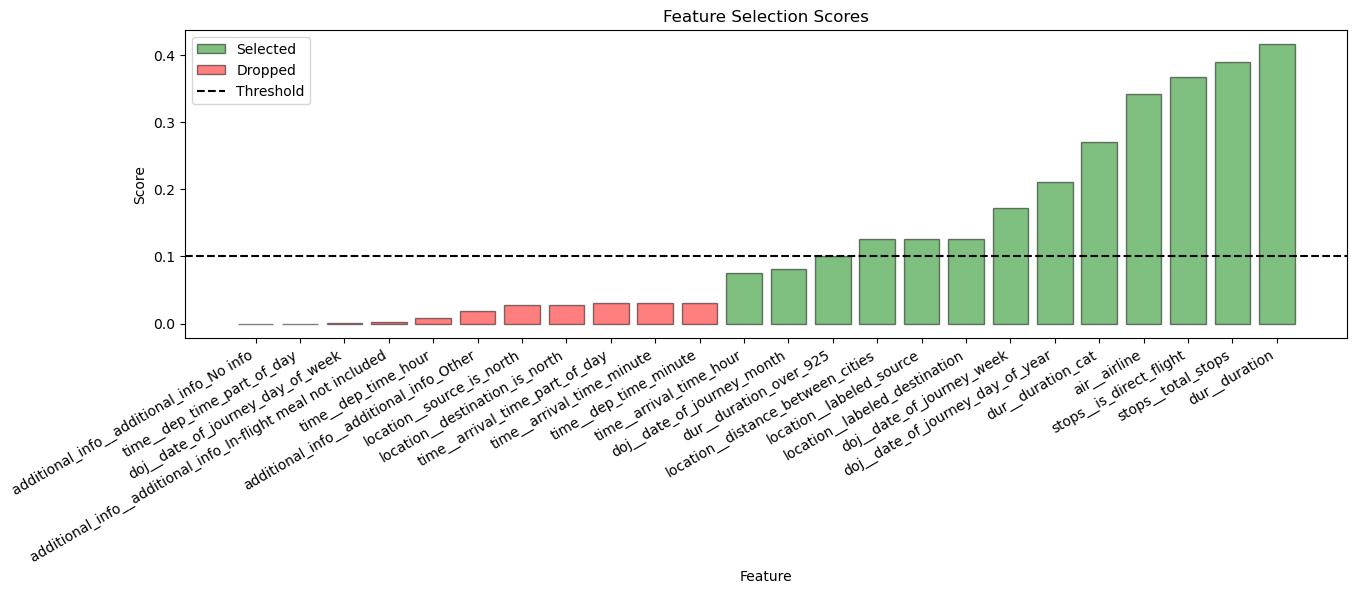

In [386]:
THRESHOLD = 0.05

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()